# Performance Estimation of 3D Segmentation

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_seg3d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hba4-D7uPKfLsbwy9EY5tFu9syXEEl_L#scrollTo=8ba3dd68-4dba-4638-9de1-ab7847d24d90)

* In this notebook, we will show how to evaluate the performance of 3D segmentation tasks.
<br>
* We provide the model predicted 3D segmentation results (network logits) for this tutorial, which will be download automatically. We also provide the model training code in https://github.com/ZerojumpLine/Robust-Medical-Segmentation.
<br>
* More specifically, we show an example of estimating the performance under domain shifts on Prostate MRI segmentation (into 2 classes including background and prostate) based on a 3D U-Net. We will utilize the calculated logits on test dataset acquired with a different scanner.
<br>
* We will calculated model confidence with different confidence scores and varied calibration methods.

In [1]:
!pip install moval
!pip install statannotations
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install nibabel
!pip install seaborn==0.12 # because statannotations not support the latest

In [2]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import nibabel as nib
import moval
from moval.solvers.utils import ComputMetric
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print(f"The installed MOVAL verision is {moval.__version__}")
print(f"The installed seaborn verision is {sns.__version__}")

The installed MOVAL verision is 0.2.19
The installed seaborn verision is 0.12.0


## Load the data

In [4]:
# download the data, which we used for MICCAI 2022

output = "data_moval.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=139pqxkG2ccIFq6qNArnFJWQ2by2Spbxt&export=download"
    output = "data_moval.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [5]:
ls

analysis_cls.ipynb    data_moval_supp.zip   img_cifar/
analysis_seg2d.ipynb  estim_cls.ipynb       img_cifar.zip
analysis_seg3d.ipynb  estim_seg2d.ipynb     img_prostate/
data_moval/           estim_seg3d.ipynb     img_prostate.zip
data_moval.zip        img_cardiac/
data_moval_supp/      img_cardiac.zip


In [6]:
# now I am playing with prostate segmentation
Datafile_eval = "data_moval/Prostateresults/seg-eval.txt"
Imglist_eval = open(Datafile_eval)
Imglist_eval_read = Imglist_eval.read().splitlines()

logits = []
gt = []
# to accelerate the debugging speed, crop the middel 60 x 60 x 30 cub for training/inference.
for Imgname_eval in Imglist_eval_read:
    GT_file = Imgname_eval.replace("data", "data_moval")
    caseID = Imgname_eval.split("/")[-1][:6]
    logit_cls0_file = "data_moval/Prostateresults/prostateval/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval/Prostateresults/prostateval/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    logit_cls0      = logit_cls0[logit_cls0.shape[0] //2 - 30: logit_cls0.shape[0] //2 + 30,
                                 logit_cls0.shape[1] //2 - 30: logit_cls0.shape[1] //2 + 30,
                                 logit_cls0.shape[2] //2 - 15: logit_cls0.shape[2] //2 + 15]
    logit_cls1      = logit_cls1[logit_cls1.shape[0] //2 - 30: logit_cls1.shape[0] //2 + 30,
                                 logit_cls1.shape[1] //2 - 30: logit_cls1.shape[1] //2 + 30,
                                 logit_cls1.shape[2] //2 - 15: logit_cls1.shape[2] //2 + 15]
    GTimg           = GTimg[GTimg.shape[0] //2 - 30: GTimg.shape[0] //2 + 30,
                            GTimg.shape[1] //2 - 30: GTimg.shape[1] //2 + 30,
                            GTimg.shape[2] //2 - 15: GTimg.shape[2] //2 + 15]
    logit_cls = np.stack((logit_cls0, logit_cls1))  # ``(d, H, W, D)``
    logits.append(logit_cls)
    gt.append(GTimg)

# logits is a list of length ``n``,  each element has ``(d, H, W, D)``. 
# gt is a list of length ``n``,  each element has ``(H, W, D)``.
# H, W and D could differ for different cases.

Datafile_test = "data_moval/Prostateresults/seg-testA.txt"
Imglist_test = open(Datafile_test)
Imglist_test_read = Imglist_test.read().splitlines()

logits_test = []
gt_test = []
for Imgname_test in Imglist_test_read:
    GT_file = Imgname_test.replace("data", "data_moval")

    caseID = Imgname_test.split("/")[-1][:6]

    logit_cls0_file = "data_moval/Prostateresults/prostattestcondition_A/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval/Prostateresults/prostattestcondition_A/results/pred_" + caseID + "cls1_prob.nii.gz"

    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls0      = logit_cls0_read.get_fdata()
    logit_cls1      = logit_cls1_read.get_fdata()
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H', W', D')``

    logit_cls = np.stack((logit_cls0, logit_cls1))  # ``(n', H', W', D')``
    
    logits_test.append(logit_cls)
    gt_test.append(GTimg)


# logits_test is a list of length ``n'``,  each element has ``(d, H', W', D')``. 
# gt_test is a list of length ``n'``,  each element has ``(H', W', D')``.
# H, W and D could differ for different cases.

In [7]:
print(f"The validation predictions, ``logits`` are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt)}, each element has approximately {gt[0].shape}\n")
print(f"The test predictions, ``logits_test`` are a list of length {len(logits_test)} each element has approximately {logits_test[0].shape}")
print(f"The test labels, ``gt_test`` are a list of length {len(gt_test)}, each element has approximately {gt_test[0].shape}")

The validation predictions, ``logits`` are a list of length 10 each element has approximately (2, 60, 60, 30)
The validation labels, ``gt`` are a list of length 10, each element has approximately (60, 60, 30)

The test predictions, ``logits_test`` are a list of length 2 each element has approximately (2, 256, 256, 40)
The test labels, ``gt_test`` are a list of length 2, each element has approximately (256, 256, 40)


## MOVAL estimation

In [8]:
moval_options = list(itertools.product(moval.models.get_estim_options(),
                               ["segmentation"],
                               moval.models.get_conf_options(),
                               [False, True]))

In [9]:
# ac-model does not need class-speicfic variants
for moval_option in moval_options:
    if moval_option[0] == 'ac-model' and moval_option[-1] == True:
        moval_options.remove(moval_option)

In [10]:
print(f"The number of moval options is {len(moval_options)}")

The number of moval options is 36


In [11]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_test, gt_test):
    """Test MOVAL with different conditions for segmentation tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of a list of n ``(d, H, W, (D))`` for segmentation. 
        gt: The cooresponding annotation of a list of n ``(H, W, (D))`` for segmentation.
        logits_test:  The network testing output (logits) of a list of n' ``(d, H', W', (D'))`` for segmentation. 
        gt_test: The cooresponding testing annotation of a list of n' ``(H', W', (D'))`` for segmentation.

    Returns:
        err_test (float): testing error.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                metric = "f1score",
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    estim_dsc_test = moval_model.estimate(logits_test)

    DSC_list_test = []
    for n_case in range(len(logits_test)):
        pred_case   = np.argmax(logits_test[n_case], axis = 0) # ``(H', W', (D'))``
        gt_case     = gt_test[n_case] # ``(H', W', (D'))``

        DSC, _, _ = ComputMetric(pred_case == 1, gt_case == 1)
        DSC_list_test.append(DSC)
    m_DSC_test = np.mean(np.array(DSC_list_test))

    err_test = np.abs( m_DSC_test - estim_dsc_test[1:] )

    return err_test, moval_model

In [12]:
err_test_list = []
moval_parameters = []
moval_parameters_ = []

In [13]:
for k_cond in tqdm(range(len(moval_options))):
    
    err_test, moval_model = test_cls(
        estim_algorithm = moval_options[k_cond][0], 
        mode = moval_options[k_cond][1], 
        confidence_scores = moval_options[k_cond][2],
        class_specific = moval_options[k_cond][3],
        logits = logits,
        gt = gt,
        logits_test = logits_test,
        gt_test = gt_test
    )
    err_test_list.append(err_test)
    moval_parameters.append(moval_model.model_.param)
    if moval_model.model_.extend_param:
        moval_parameters_.append(moval_model.model_.param_ext)
    else:
        moval_parameters_.append(0.)

  0%|                                                                                                                                                                 | 0/36 [00:00<?, ?it/s]

Starting optimizing for model ac-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Calculating and saving the fitted case-wise performance...


  3%|████▎                                                                                                                                                    | 1/36 [00:01<01:07,  1.94s/it]

Starting optimizing for model ac-model with confidence energy-conf based on metric f1score, class specific is False.
Calculating and saving the fitted case-wise performance...


  6%|████████▌                                                                                                                                                | 2/36 [00:03<00:53,  1.58s/it]

Starting optimizing for model ac-model with confidence entropy-conf based on metric f1score, class specific is False.
Calculating and saving the fitted case-wise performance...


  8%|████████████▊                                                                                                                                            | 3/36 [00:04<00:53,  1.62s/it]

Starting optimizing for model ac-model with confidence doctor-conf based on metric f1score, class specific is False.
Calculating and saving the fitted case-wise performance...


 11%|█████████████████                                                                                                                                        | 4/36 [00:06<00:52,  1.64s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 14%|█████████████████████▎                                                                                                                                   | 5/36 [00:16<02:18,  4.45s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 17%|█████████████████████████▌                                                                                                                               | 6/36 [00:38<05:21, 10.72s/it]

Starting optimizing for model ts-model with confidence energy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...


/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/utils.py:39: RuntimeWarning: overflow encountered in exp
  denominator = np.sum(np.exp(x.transpose() / T), axis=0)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/utils.py:40: RuntimeWarning: divide by zero encountered in log
  energy = - T * np.log(denominator)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:150: RuntimeWarning: invalid value encountered in subtract
  normalized_score =  (scores[n_case] - self.min_value) / (self.max_value - self.min_value + e1)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:150: RuntimeWarning: invalid value encountered in divide
  normalized_score =  (scores[n_case] - self.min_value) / (self.max_value - self.min_value + e1)


Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Calculating and saving the fitted case-wise performance...


 19%|█████████████████████████████▊                                                                                                                           | 7/36 [01:17<09:34, 19.82s/it]

Starting optimizing for model ts-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Starting optimizing for model ts-model with confidence energy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 22%|██████████████████████████████████                                                                                                                       | 8/36 [02:12<14:30, 31.08s/it]

Starting optimizing for model ts-model with confidence entropy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 25%|██████████████████████████████████████▎                                                                                                                  | 9/36 [02:21<10:51, 24.13s/it]

Starting optimizing for model ts-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-model with confidence entropy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 28%|██████████████████████████████████████████▏                                                                                                             | 10/36 [02:40<09:48, 22.63s/it]

Starting optimizing for model ts-model with confidence doctor-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 31%|██████████████████████████████████████████████▍                                                                                                         | 11/36 [02:49<07:38, 18.35s/it]

Starting optimizing for model ts-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-model with confidence doctor-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 33%|██████████████████████████████████████████████████▋                                                                                                     | 12/36 [03:11<07:44, 19.35s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 36%|██████████████████████████████████████████████████████▉                                                                                                 | 13/36 [03:19<06:06, 15.92s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model doc-model with confidence max_class_probability-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 39%|███████████████████████████████████████████████████████████                                                                                             | 14/36 [03:38<06:11, 16.86s/it]

Starting optimizing for model doc-model with confidence energy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 42%|███████████████████████████████████████████████████████████████▎                                                                                        | 15/36 [03:44<04:50, 13.81s/it]

Starting optimizing for model doc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model doc-model with confidence energy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 44%|███████████████████████████████████████████████████████████████████▌                                                                                    | 16/36 [04:01<04:53, 14.69s/it]

Starting optimizing for model doc-model with confidence entropy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 47%|███████████████████████████████████████████████████████████████████████▊                                                                                | 17/36 [04:09<04:02, 12.76s/it]

Starting optimizing for model doc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model doc-model with confidence entropy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 18/36 [04:28<04:21, 14.52s/it]

Starting optimizing for model doc-model with confidence doctor-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                       | 19/36 [04:35<03:30, 12.40s/it]

Starting optimizing for model doc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model doc-model with confidence doctor-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 20/36 [04:53<03:44, 14.03s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 21/36 [05:02<03:07, 12.53s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model atc-model with confidence max_class_probability-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 61%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 22/36 [05:23<03:28, 14.89s/it]

Starting optimizing for model atc-model with confidence energy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Calculating and saving the fitted case-wise performance...


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 23/36 [05:34<02:59, 13.79s/it]

Starting optimizing for model atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Starting optimizing for model atc-model with confidence energy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param for class 1, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Calculating and saving the fitted case-wise performance...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 24/36 [06:15<04:23, 21.95s/it]

Starting optimizing for model atc-model with confidence entropy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 25/36 [06:25<03:23, 18.49s/it]

Starting optimizing for model atc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model atc-model with confidence entropy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 26/36 [06:49<03:20, 20.06s/it]

Starting optimizing for model atc-model with confidence doctor-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 27/36 [06:58<02:30, 16.76s/it]

Starting optimizing for model atc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model atc-model with confidence doctor-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 28/36 [07:19<02:24, 18.11s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 29/36 [07:36<02:04, 17.73s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-atc-model with confidence max_class_probability-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 30/36 [08:20<02:33, 25.58s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Calculating and saving the fitted case-wise performance...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 31/36 [09:11<02:46, 33.21s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Starting optimizing for model ts-atc-model with confidence energy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param_ext for class 1, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
[(0.9304117706049815, 1.0), (2.0998442107345028e-07, 0.8692247859713023), (0.069588229123139, 0.8262631444713193)]
Calculating and saving the fitted case-wise performance...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 32/36 [10:58<03:41, 55.33s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 33/36 [11:15<02:11, 43.92s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 34/36 [11:58<01:26, 43.39s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 35/36 [12:14<00:35, 35.46s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-atc-model with confidence doctor-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [12:59<00:00, 21.64s/it]


## Compare estimation results

In [14]:
estim = []
conf = []
err = []
err_mean = []
novel = []
k_option = 0
for moval_option in moval_options:
    for k_cond in range(len(err_test_list[k_option])):
        #
        if moval_option[3] == True:
            estim_cs = 'CS '
        else:
            estim_cs = ''
        #    
        if moval_option[0] == 'ac-model':
            estim.append(estim_cs + 'AC')
        elif moval_option[0] == 'ts-model':
            estim.append(estim_cs + 'TS')
        elif moval_option[0] == 'doc-model':
            estim.append(estim_cs + 'DoC')
        elif moval_option[0] == 'atc-model':
            estim.append(estim_cs + 'ATC')
        else:
            estim.append(estim_cs + 'TS-ATC')
        #
        if moval_option[2] == 'max_class_probability-conf':
            conf.append('MCP')
        elif moval_option[2] == 'energy-conf':
            conf.append('Energy')
        elif moval_option[2] == 'entropy-conf':
            conf.append('Entropy')
        else:
            conf.append('Doctor')
        #
        if moval_option[2] == 'max_class_probability-conf' and moval_option[3] == False:
            novel.append('Existing Methods')
        else:
            novel.append('Provided by MOVAL')
        #
        err.append(err_test_list[k_option][k_cond])
        err_mean.append(np.mean(err_test_list[k_option]))
    k_option += 1

In [15]:
d = {'Estimation Algorithm': estim, 'Confidence Score': conf, 'MAE': err_mean, 'MAE ': err, 'Category': novel}
df = pd.DataFrame(data=d)
#
custom_order = ['AC', 'TS', 'DoC', 'ATC', 'TS-ATC', 'CS TS', 'CS DoC', 'CS ATC', 'CS TS-ATC']
df['Estimation Algorithm'] = pd.Categorical(df['Estimation Algorithm'], categories=custom_order, ordered=True)
df = df.sort_values(by='Estimation Algorithm')
#
custom_order = ['MCP', 'Doctor', 'Entropy', 'Energy']
df['Confidence Score'] = pd.Categorical(df['Confidence Score'], categories=custom_order, ordered=True)
df = df.sort_values(by='Confidence Score')

In [16]:
df.head()

,Estimation Algorithm,Confidence Score,MAE,MAE,Category
0,AC,MCP,0.169580,0.169580,Existing Methods
29,CS TS-ATC,MCP,0.003049,0.003049,Provided by MOVAL
21,CS ATC,MCP,0.003049,0.003049,Provided by MOVAL
4,TS,MCP,0.126593,0.126593,Existing Methods
13,CS DoC,MCP,0.110844,0.110844,Provided by MOVAL


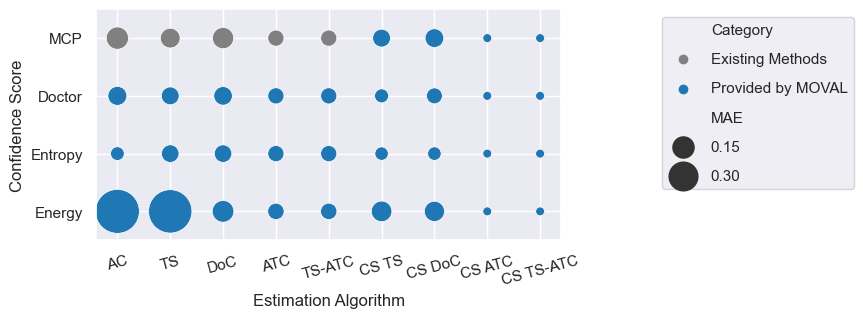

In [17]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set_style("darkgrid")
category_palette = {'Existing Methods': 'grey', 'Provided by MOVAL': '#1f77b4'}
ax = sns.scatterplot(
    data=df, x="Estimation Algorithm", y="Confidence Score", hue="Category", size="MAE",
    sizes=(40, 1000), palette=category_palette
)
ax.set(ylim=(3.5, -0.5))
ax.tick_params(axis='x', rotation=15)
#
# Get the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# Create a custom legend with only desired categories
desired_labels = ['Category', 'Existing Methods', 'Provided by MOVAL', 'MAE', '0.15', '0.30']
desired_handles = [h for h, l in zip(handles, labels) if l in desired_labels]

legend = plt.legend(handles=desired_handles, labels=desired_labels, bbox_to_anchor=(1.2, 1), labelspacing=1)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TS vs. CS TS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.857e-01 U_stat=1.100e+01
DoC vs. CS DoC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.429e-01 U_stat=1.200e+01
ATC vs. CS ATC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.558e-02 U_stat=1.600e+01
TS-ATC vs. CS TS-ATC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.558e-02 U_stat=1.600e+01


(<Axes: xlabel='Estimation Algorithm', ylabel='MAE'>,
  <statannotations.Annotation.Annotation at 0x7faef9197dc0>])

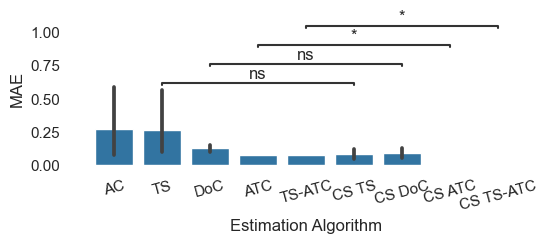

In [18]:
from statannotations.Annotator import Annotator
sns.set(rc={'figure.figsize':(6,2)})
sns.set_style("white")
ax = sns.barplot(df, x="Estimation Algorithm", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
#
pairs=[("TS", "CS TS"), ("DoC", "CS DoC"), ("ATC", "CS ATC"), ("TS-ATC", "CS TS-ATC")]

annotator = Annotator(ax, pairs, data=df, x="Estimation Algorithm", y="MAE")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCP vs. Doctor: Mann-Whitney-Wilcoxon test two-sided, P_val:1.826e-01 U_stat=5.600e+01
MCP vs. Entropy: Mann-Whitney-Wilcoxon test two-sided, P_val:9.103e-02 U_stat=6.000e+01
MCP vs. Energy: Mann-Whitney-Wilcoxon test two-sided, P_val:4.263e-01 U_stat=3.100e+01


(<Axes: xlabel='Confidence Score', ylabel='MAE'>,
  <statannotations.Annotation.Annotation at 0x7faed81181f0>])

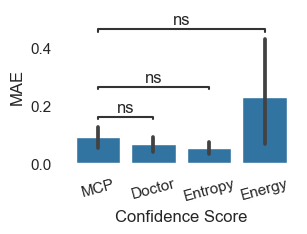

In [19]:
sns.set(rc={'figure.figsize':(3,2)})
sns.set_style("white")
ax = sns.barplot(df, x="Confidence Score", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
#
pairs=[("MCP", "Doctor"), ("MCP", "Entropy"), ("MCP", "Energy")]

annotator = Annotator(ax, pairs, data=df, x="Confidence Score", y="MAE")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATC_MCP vs. CS TS-ATC_MCP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00


[(-0.02, 0.3)]

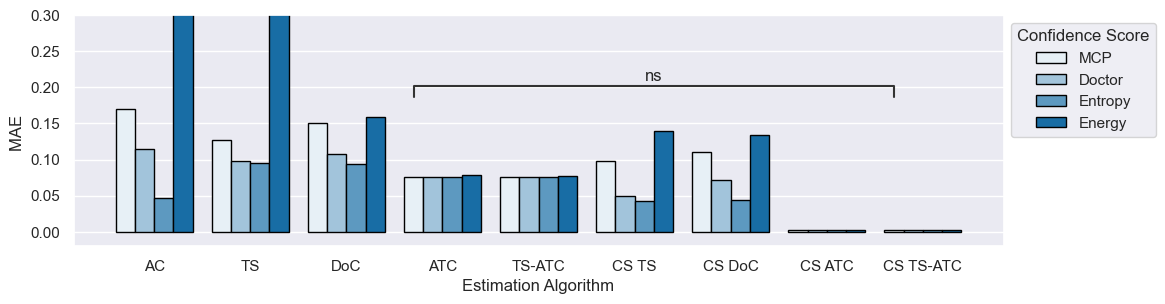

In [20]:
sns.set(rc={'figure.figsize':(12,3)})
category_palette = {'MCP': '#e5f0f8',
                    'Doctor': '#99c6e4',
                    'Entropy': '#4c9cd0',
                    'Energy': '#0072bd'
                   }
ax = sns.barplot(df, x="Estimation Algorithm", y="MAE ", hue="Confidence Score", palette=category_palette, edgecolor="0")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


pairs=[
    [("ATC", "MCP"), ("CS TS-ATC", "MCP")]
]

annotator = Annotator(ax, pairs, data=df, x="Estimation Algorithm", y="MAE", hue="Confidence Score")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set(ylim=(-0.02, 0.3))